## Preparation
This section loads the necessary data.

## Get universe

In [1]:
# This data was downloaded from https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
import pandas as pd
stocks = pd.read_csv('sp_500.csv')
stocks

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
500,YUM,Yum! Brands Inc,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
501,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
502,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [2]:
sector_dict = dict(zip(stocks["Symbol"],stocks["GICS Sector"]))
subsector_dict = dict(zip(stocks["Symbol"],stocks["GICS Sub-Industry"]))

## Get daily stock prices

In [3]:
# from pandas_datareader import data as pdr
# import yfinance as yf
# yf.pdr_override() 

# # download dataframe
# universe = list(stocks.Symbol.values)

# test = pdr.get_data_yahoo(universe, start="2015-01-01", end="2023-01-01")
# yahoo_prices = test['Adj Close']
# yahoo_prices.reset_index().to_csv("yahoo_prices_2015_to_2022.csv", index=False)

### Goal
In this project, I aim to create 11 clusters that would be as close to the true GICS sectors as possible. \
I would value such clustering as good if each of my predicted clusters contained at least 50% of any one of the true GICS clusters. 


### Imports

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Patch

from sklearn.cluster import SpectralCoclustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### Tools

In [6]:
def flatten(l: list) -> list:
    """
    turns a list of lists into "level 1" list
    e.g. [[1], [2]]  -- > [1, 2]
    """
    return [item for sublist in l for item in sublist]


def melt_df(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """
    Returns a dataframe that stores all values of input dataframe in one select column
    """
    df = pd.melt(df, id_vars=['date'], var_name='id', value_name=col_name)
    df = df.astype({"date": 'datetime64[ns]', "id": 'str'})
    df.sort_values(by = ['date', 'id'], inplace = True)   

    return df 


def create_test_df(predictions_dict: dict) -> pd.DataFrame:
    """
    Returns the intersection matrix, whose (i,j)-th value shows us the proportion of 
    j-th sector captured in i-th predicted cluster.
    """

    test_df = pd.DataFrame(columns = sector_list)

    for i in range(0,len(predictions_dict)):
        new_row = []
        for sector in sector_list:
            intersection = np.intersect1d(predictions_dict[i], Sector_dict_numerical[sector])
            new_value = len(intersection)/len(Sector_dict_numerical[sector])
            new_row.append(new_value)

        test_df.loc[len(test_df.index)] = new_row

    return test_df


def _color_red_or_green(val: float):
    """
    Colours dataframes entries according to the rule below
    """
    if val > 0.499:
        color = 'lightgreen' 
    elif val > 0.0:
        color = 'green'
    else:
        color = 'white'
    return 'color: %s' % color


def create_1d_test_df(all_sector_info_df: pd.DataFrame, method_name: str) -> pd.DataFrame:
    """
    all_sector_info_df: the intersection matrix, whose (i,j)-th value shows us the proportion of 
    j-th sector captured in i-th predicted cluster.

    Returns a dataframe with:
        the maximum proportion of a sector captured by one of our predicted clusters.
        the proportion of our predicted clusters that captured largest chunk of any of the sectors
    """
    max_sector_predicted_df = pd.DataFrame(columns = [method_name])
    unique_prediction_ids = set()
    for sector in sector_list:
        unique_prediction_ids.add(all_sector_info_df[sector].idxmax())
        max_sector_predicted_df.loc[sector] = all_sector_info_df[sector].max()

    max_sector_predicted_df.loc["pct_pred_clusters"] = len(unique_prediction_ids)/len(all_sector_info_df)

    return max_sector_predicted_df.transpose()


def get_proportion(df1: pd.DataFrame, df2: pd.DataFrame, col: str, q: float) -> float:
    """
    Returns a proportion of data points in df1[col] whose value is greater than (or geometrically: to the right of) 
    the q-th quantile of df2[col]
    """
    return len(df1[df1[col] > np.quantile(df2[col], q)]) / len(df1)


def get_pair_corr_df(data_df:pd.DataFrame, metric_choice: str) -> pd.DataFrame:
    """
    Returns a matrix will all correlations for any distinct company pair. 
    Records the company symbols and which sector their belong to.
    """
    # Compute pairwise correlation of columns, excluding NA/null values.
    corr_df = data_df.pivot(index='date', columns='id')[metric_choice].corr() 

    corr_df.rename(columns=company_to_id_dict,inplace=True)
    corr_df.rename(index=company_to_id_dict,inplace=True)

    df = corr_df.reset_index().drop(['id'], axis = 1)
    df["id_left"] = df.index

    pair_corr_df = pd.melt(df, id_vars=['id_left'], var_name='id_right', value_name=metric_choice)

    # remove self-correlations and duplicates
    pair_corr_df = pair_corr_df[pair_corr_df['id_left'] > pair_corr_df['id_right']].copy()

    pair_corr_df['company_1'] = pair_corr_df['id_left'].map(id_to_company_dict)
    pair_corr_df['company_2'] = pair_corr_df['id_right'].map(id_to_company_dict)
    pair_corr_df['sector_1'] = pair_corr_df['company_1'].map(sector_dict) 
    pair_corr_df['sector_2'] = pair_corr_df['company_2'].map(sector_dict) 

    return pair_corr_df


### Fetch Data

In [7]:
# prices = pd.read_csv('sp_500_prices.csv')
prices = pd.read_csv("yahoo_prices_2015_to_2022.csv")

prices.rename(columns={"Date" : "date"}, inplace = True)
prices = prices.astype({"date": 'datetime64[ns]'})
prices.head()

,date,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2015-01-02,37.751774,51.079922,145.942047,24.498688,45.607632,78.930321,37.310001,38.058819,76.840805,...,27.865789,NaN,62.658436,48.433239,34.026733,44.099751,102.223511,77.430000,23.135225,40.775246
1,2015-01-05,37.044376,51.051498,144.018433,23.808517,44.749313,78.258423,37.070000,38.067291,75.543396,...,27.549486,NaN,60.943989,48.097485,31.909000,43.203743,106.036789,76.339996,22.268373,40.530460
2,2015-01-06,36.467312,50.255585,143.917160,23.810753,44.527817,78.685982,36.130001,37.634979,74.998497,...,27.696068,NaN,60.619984,47.500576,31.721354,42.673450,105.137970,75.790001,21.417873,40.135048
3,2015-01-07,36.951313,50.227158,147.009720,24.144636,46.327488,80.256561,37.279999,37.940136,76.572678,...,27.935219,NaN,61.234241,48.731697,31.971544,44.087563,107.752777,77.720001,21.622322,40.963551
4,2015-01-08,38.058918,50.843040,148.298340,25.072329,46.812008,80.439804,38.959999,38.719975,77.740341,...,28.259241,NaN,62.253464,49.934834,32.212795,44.855572,108.896759,79.379997,21.924908,41.594326


### Parameters

In [8]:
# horizons we'll check to determine most informative type of returns
horizons_to_check_choice = [1, 5]

# returns I will choose from
metric_list = ['ret_1d', 'ret_5d', 'hret_1d', 'hret_5d', 'ewm_ret_1d', 'wt_hret_1d']

# center of mass choice for exponentially weighted calculations
com_choice = 0.5

# number of clusters we aim to create from prices only
no_clusters = 11

# minimum proportion of variance that we want to capture when projecting data with PCA
explained_variance_threshold = 0.95

### Prep Data

#### Drop NaNs

In [9]:
prices.isna().sum().describe()

count     506.000000
mean      134.693676
std       482.492812
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2014.000000
dtype: float64

In [10]:
prices = prices.dropna(axis = 1)

data_df = melt_df(prices, "adj_close").reset_index()
data_df.head()

,index,date,id,adj_close
0,0,2015-01-02,A,37.751774
1,2014,2015-01-02,AAL,51.079922
2,4028,2015-01-02,AAP,145.942047
3,6042,2015-01-02,AAPL,24.498688
4,8056,2015-01-02,ABBV,45.607632


#### Prep Returns

In [11]:
for i in horizons_to_check_choice:
    # previous adj_close
    data_df[f"prv_adj_close{i}d"] = data_df.groupby('id')["adj_close"].shift(i)
    # raw returns
    data_df[f"ret_{i}d"] = (data_df['adj_close'] - data_df[f'prv_adj_close{i}d'])/data_df['adj_close'] 
    # hedged returns
    data_df[f"hret_{i}d"] = data_df.groupby('date')[f"ret_{i}d"].apply(lambda x: x - np.mean(x)).reset_index(drop = True)

data_df["ewm_ret_1d"] = data_df["ret_1d"].ewm(com = com_choice).mean()

# Get "wt_hret_1d" - hedged returns calculated with weights proportional to close price
data_df['sum_adj_close'] = data_df.groupby('date')["adj_close"].transform("sum")
data_df['wt_ret_1d'] = (data_df["adj_close"] / data_df['sum_adj_close']) * data_df['ret_1d']
data_df['wt_index_ret_1d'] = data_df.groupby('date')["wt_ret_1d"].transform("sum")
data_df["wt_hret_1d"] = data_df["ret_1d"] - data_df['wt_index_ret_1d']

# Check how similar the two different hedged returns are
data_df[['hret_1d', 'wt_hret_1d']].corr()

,hret_1d,wt_hret_1d
hret_1d,1.000000,0.988011
wt_hret_1d,0.988011,1.000000


#### Sector Info 

In [12]:
data_df['Sector'] = data_df['id'].map(sector_dict)
data_df['SubSector'] = data_df['id'].map(subsector_dict)
data_df.sort_values(by = ['date', 'Sector', 'SubSector'], inplace = True)

sector_df = pd.DataFrame(index = data_df['Sector'].unique())
sector_df['constituents'] = data_df.groupby('Sector')['id'].unique()
sector_df['size'] = data_df.groupby('Sector')['id'].nunique()
sector_list = list(sector_df.index)
sector_df

,constituents,size
Communication Services,"[IPG, OMC, LUMN, CHTR, CMCSA, DISH, T, VZ, ATV...",19
Consumer Discretionary,"[GPS, ROST, TJX, HBI, NKE, PVH, RL, TPR, UAA, ...",60
Consumer Staples,"[ADM, TAP, STZ, WBA, SYY, KR, CHD, CL, CLX, KM...",29
Energy,"[CVX, HES, XOM, BKR, HAL, NOV, SLB, APA, COP, ...",21
Financials,"[AMP, BEN, BK, BLK, IVZ, NTRS, STT, TROW, AXP,...",60
Health Care,"[AMGN, BIIB, GILD, INCY, REGN, VRTX, ABC, BMY,...",58
Industrials,"[BA, GD, HII, LHX, LMT, NOC, RTX, TDG, TDY, TX...",65
Information Technology,"[ADBE, ADSK, ANSS, CDNS, CRM, INTU, ORCL, PAYC...",67
Materials,"[MLM, VMC, FCX, EMN, CF, FMC, MOS, NEM, APD, L...",24
Real Estate,"[PEAK, VTR, WELL, HST, PLD, ARE, BXP, VNO, CBR...",28


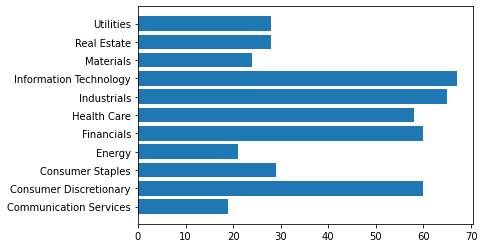

In [13]:
# Sector sizes
_ = plt.barh(sector_df.index, sector_df['size'])

#### Encode companies and sectors numerically

In [14]:
# data_df is sorted above
company_list = np.unique(data_df.id.values)
company_to_id_dict = {company_list[i]:i for i in range(len(company_list))}
id_to_company_dict = {i:company_list[i] for i in range(len(company_list))}

Sector_dict = dict()
for i in range(len(sector_list)):
    Sector_dict[sector_df[i:i+1].index[0]] = sector_df[i:i+1]['constituents'].values[0]
    
Sector_dict_numerical = dict()
for i in range(len(sector_list)):
    Sector_dict_numerical[sector_df[i:i+1].index[0]] = [company_to_id_dict[j] for j in sector_df[i:i+1]['constituents'].values[0]]

### Choose metric
Record correlations of all company pairs for all metrics of interest in pair_corr_df

In [15]:
for i in range(len(metric_list)):
    if i == 0 :
        pair_corr_df = get_pair_corr_df(data_df, metric_list[i])
    else:
        join_df = get_pair_corr_df(data_df, metric_list[i])[['company_1', 'company_2', metric_list[i]]].set_index(['company_1', 'company_2'])
        pair_corr_df = pair_corr_df.set_index(['company_1', 'company_2']).join(join_df, how = 'left').reset_index()

pair_corr_df.head()

,company_1,company_2,id_left,id_right,ret_1d,sector_1,sector_2,ret_5d,hret_1d,hret_5d,ewm_ret_1d,wt_hret_1d
0,AAL,A,1,0,0.338993,Industrials,Health Care,0.324105,-0.131680,-0.224208,0.459779,-0.074307
1,AAP,A,2,0,0.310868,Consumer Discretionary,Health Care,0.275508,-0.093407,-0.193677,0.408122,-0.144172
2,AAPL,A,3,0,0.541098,Information Technology,Health Care,0.498559,0.149111,0.191701,0.524888,0.054609
3,ABBV,A,4,0,0.414974,Health Care,Health Care,0.379011,0.137541,0.104528,0.504485,0.080805
4,ABC,A,5,0,0.363956,Health Care,Health Care,0.356570,0.011916,0.120102,0.428758,-0.035475


#### Returns behaviour plot

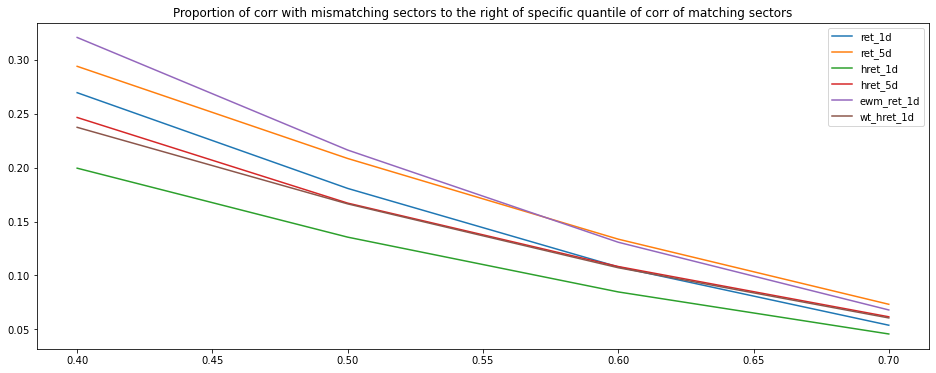

In [16]:
sector_match = pair_corr_df.loc[pair_corr_df["sector_1"] == pair_corr_df["sector_2"]].copy()
sector_mismatch = pair_corr_df.loc[pair_corr_df["sector_1"] != pair_corr_df["sector_2"]].copy()

plt.figure(figsize=(16, 6))
ticks = np.arange(0.4,0.8, 0.1)

percent_dict_per_return = dict()
min_percent = 1
max_percent = 0
best_return = str()
worst_return = str()

for metric in metric_list:
    percent_dict_per_return[metric] = [get_proportion(sector_mismatch, sector_match, metric, q) for q in ticks]
    mean_percent_per_metric = np.mean(percent_dict_per_return[metric])
    if  mean_percent_per_metric > max_percent:
        max_percent = mean_percent_per_metric
        worst_return = metric
    if mean_percent_per_metric < min_percent:
        min_percent = mean_percent_per_metric
        best_return = metric

    plt.plot(ticks, percent_dict_per_return[metric], label = metric)

plt.title('Proportion of corr with mismatching sectors to the right of specific quantile \
of corr of matching sectors')    
_ = plt.legend()

#### Best vs Worst metric

From the graph above, we define best and worst choice for metrics as follows: \
Fix a metric M \
Let sector_match be the set of all correlations of M of company pairs with matching sectors \
Let sector_mismatch be "----------------------------------------" with non-matching sectors 

Let m be the mean correlation of a metric M among pairs with matching sectors \
Let p be the proportion of correlations greater than m of metric M among pairs with nonmatching sectors 

Then best_metric := M for which p is minimised \
and worst_metric := M for which p is maximised



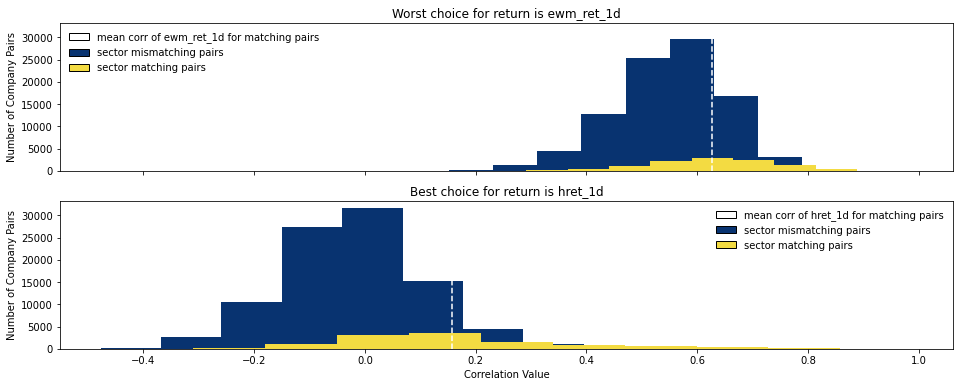

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(16, 6), sharex = True, sharey = True)

cmap = plt.cm.get_cmap('cividis')
color_1 = cmap(0.1)
color_2 = cmap(0.95)

axs[0].hist(sector_mismatch[worst_return], label = "sector mismatching pairs", color = color_1)
axs[0].hist(sector_match[worst_return], label = "sector matching pairs", color = color_2)
mean_corr_worst = np.mean(sector_match[worst_return])
axs[0].plot([mean_corr_worst, mean_corr_worst], [0,30000], label = f"mean corr of {worst_return} for matching pairs", color = 'white', linestyle='dashed')
axs[0].set_title(f'Worst choice for return is {worst_return}')
axs[0].set_ylabel("Number of Company Pairs")

axs[1].hist(sector_mismatch[best_return], label = "sector mismatching pairs", color = color_1)
axs[1].hist(sector_match[best_return], label = "sector matching pairs", color = color_2)
mean_corr_best = np.mean(sector_match[best_return])
axs[1].plot([mean_corr_best, mean_corr_best], [0,30000], label = f"mean corr of {best_return} for matching pairs", color = 'white', linestyle='dashed')
axs[1].set_title(f'Best choice for return is {best_return}')
axs[1].set_ylabel("Number of Company Pairs")

plt.xlabel('Correlation Value')
colors = ['white', color_1, color_2]

handles, labels = axs[0].get_legend_handles_labels()
outline_handles = [Patch(facecolor=color, edgecolor='black', label=label) for color, label in zip(colors, labels)]
axs[0].legend(handles=outline_handles, edgecolor = 'white')

handles, labels = axs[1].get_legend_handles_labels()
outline_handles = [Patch(facecolor=color, edgecolor='black', label=label) for color, label in zip(colors, labels)]
_ = axs[1].legend(handles=outline_handles, edgecolor = 'white')


In [18]:
metric_choice = best_return

#### Histograms per Sector
Plot that shows correlation distribution can help detect only certain sectors

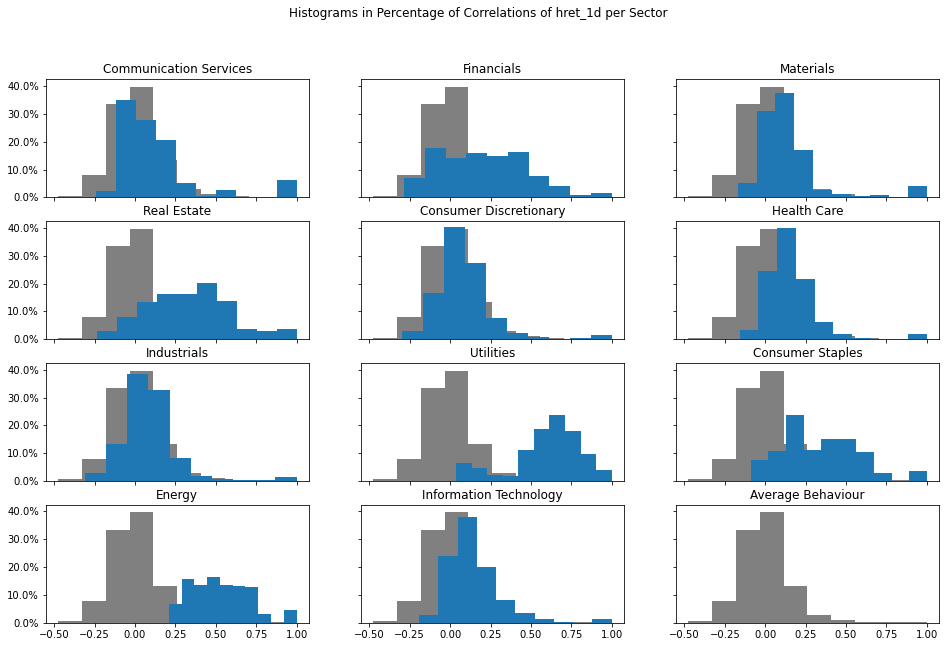

In [19]:
fig, axs = plt.subplots(4, 3, figsize=(16, 10), sharex = True, sharey = True)

ax = axs[3,2]
all_corr = data_df.pivot(index='date', columns='id')[metric_choice].corr()
all_corr_data = flatten(all_corr.values)
ax.hist(all_corr_data, weights=np.ones(len(all_corr_data)) / len(all_corr_data), color = "grey")

ax.set_title("Average Behaviour")

for i in range(len(sector_list)):

    ax = axs[i%4,i%3]
    column = sector_list[i]
    sector_corr = data_df[data_df['Sector'] == column].pivot(index='date', columns='id')[metric_choice].corr()
    data = flatten(sector_corr.values)

    # plots average behaviour
    ax.hist(all_corr_data, weights=np.ones(len(all_corr_data)) / len(all_corr_data), color = "grey")

    # plots sector-specific behaviour
    ax.hist(data, weights=np.ones(len(data)) / len(data))
    ax.set_title(column)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
_ = fig.suptitle(f'Histograms in Percentage of Correlations of {metric_choice} per Sector')

#### Sector Heatmap
True clustering that appears when we create the correlations matrix

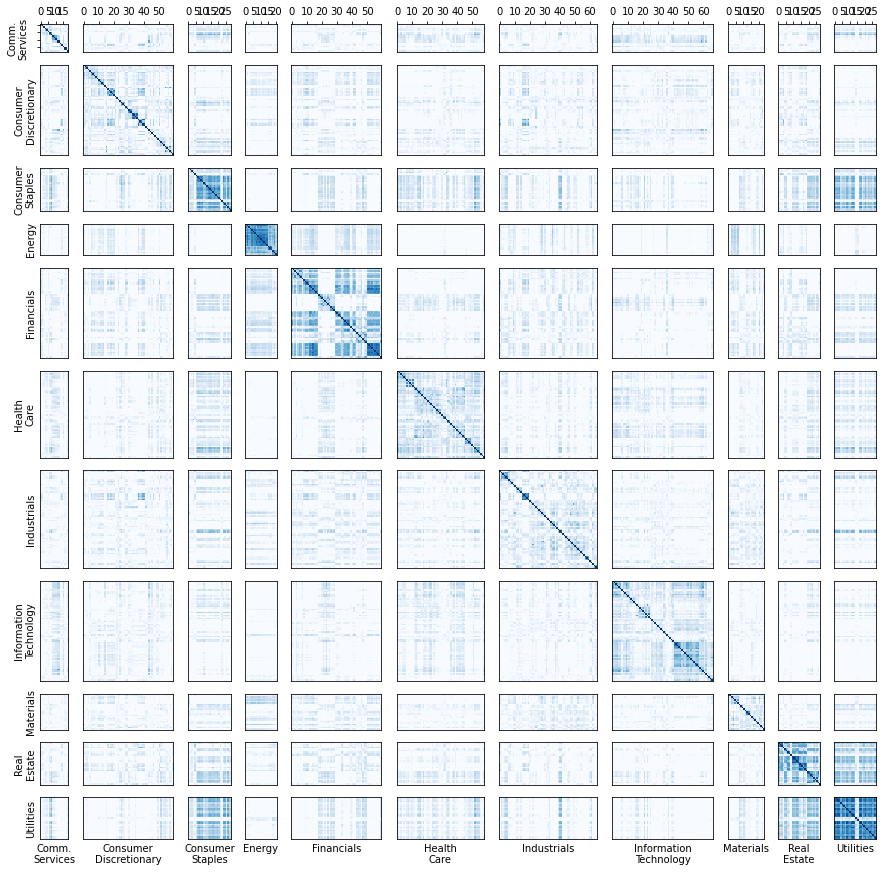

In [20]:
# Clustered by GICS Sectors
corr_df = data_df.pivot(index='date', columns=['Sector', 'SubSector', 'id'])[metric_choice].corr()

fig, axs = plt.subplots(11,11,figsize=(15, 15),gridspec_kw={'width_ratios':sector_df["size"].values, 'height_ratios':sector_df["size"].values})

for i in range(len(sector_list)):
    for j in range(len(sector_list)):

        sp = axs[i,j].matshow(corr_df.loc[sector_list[i],sector_list[j]], cmap=plt.cm.Blues,
                    vmin=0.0, vmax=1.0, 
                    interpolation='none', label = f'{i},{j}')
                    
        if i == 0 and j == 0:
            axs[i,j].tick_params(right = False, labelbottom = False, bottom = False)
        
        elif i == 0:
            axs[i,j].tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False)

        else:
            axs[i,j].tick_params(left = False, right = False, labelleft = False, top=False, labeltop=False,
                labelbottom = False, bottom = False)

label_list = [s.replace(' ', '\n') for s in sector_list]
label_list = [s.replace('Communication', 'Comm.') for s in label_list]

for ax,l in zip(axs[10,:],label_list):
    ax.set_xticklabels([])
    ax.set_xlabel(l)

for ax,l in zip(axs[:,0],label_list):
    ax.set_yticklabels([])
    ax.set_ylabel(l)

# fig.colorbar(sp, ax=axs[:,:], shrink=0.5, location = 'bottom')

## Predict & Test

In [21]:
corr_df = data_df.pivot(index='date', columns='id')[metric_choice].corr() 

corr_df.rename(columns=company_to_id_dict,inplace=True)
corr_df.rename(index=company_to_id_dict,inplace=True)

### method 1

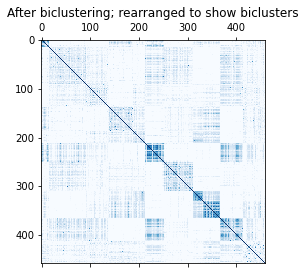

In [22]:
data = corr_df.copy()
model = SpectralCoclustering(n_clusters=no_clusters, random_state=0)
model.fit(data)

fit_data = data[np.argsort(model.row_labels_)]
fit_data = fit_data.reindex(np.argsort(model.column_labels_))

plt.matshow(fit_data, cmap=plt.cm.Blues, vmin=0.0, vmax=1.0)
_ = plt.title("After biclustering; rearranged to show biclusters")

### method 1 test

In [23]:
method_1_name = 'SpectralCoCluster'

Sector_predictions_dict = dict()
Sector_predictions_dict[method_1_name] = dict()
for i in range(no_clusters):
    Sector_predictions_dict[method_1_name][i] = model.get_indices(i)[0]

Sector_predictions_test_dict = dict()
Sector_predictions_test_dict[method_1_name] = dict()

all_sector_info_df = create_test_df(Sector_predictions_dict[method_1_name])
Sector_predictions_test_dict[method_1_name]['all_sector_info_df'] = all_sector_info_df

print('Note the i-th row corresponds to the i-th predicted cluster and the (i,j)-th entry in this dataframe shows\n\
the proportion of j-th sector captured in i-th predicted cluster.')
all_sector_info_df.style.applymap(_color_red_or_green).format("{:.2%}")

Note the i-th row corresponds to the i-th predicted cluster and the (i,j)-th entry in this dataframe shows
the proportion of j-th sector captured in i-th predicted cluster.


,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,0.00%,0.00%,3.45%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,53.57%,3.57%
1,21.05%,21.67%,10.34%,0.00%,10.00%,48.28%,9.23%,19.40%,4.17%,7.14%,0.00%
2,15.79%,0.00%,3.45%,0.00%,3.33%,8.62%,35.38%,10.45%,20.83%,0.00%,0.00%
3,10.53%,48.33%,0.00%,0.00%,5.00%,3.45%,12.31%,2.99%,0.00%,10.71%,0.00%
4,0.00%,1.67%,0.00%,9.52%,0.00%,0.00%,15.38%,2.99%,41.67%,0.00%,3.57%
5,0.00%,1.67%,10.34%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,28.57%,92.86%
6,21.05%,5.00%,0.00%,0.00%,3.33%,13.79%,1.54%,62.69%,0.00%,0.00%,0.00%
7,0.00%,0.00%,0.00%,90.48%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
8,0.00%,0.00%,0.00%,0.00%,56.67%,0.00%,1.54%,0.00%,0.00%,0.00%,0.00%
9,10.53%,0.00%,72.41%,0.00%,3.33%,22.41%,10.77%,1.49%,4.17%,0.00%,0.00%


In [24]:
all_sector_info_df = Sector_predictions_test_dict[method_1_name]['all_sector_info_df']
test_df = create_1d_test_df(all_sector_info_df, method_1_name)

Sector_predictions_test_dict[method_1_name]['1d_sector_info_df'] = test_df
print('Note the dataframe shows the maximum proportion of a sector captured by one of our predicted clusters.')
test_df.style.applymap(_color_red_or_green).format("{:.2%}")

Note the dataframe shows the maximum proportion of a sector captured by one of our predicted clusters.


,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities,pct_pred_clusters
SpectralCoCluster,21.05%,48.33%,72.41%,90.48%,56.67%,48.28%,35.38%,62.69%,41.67%,53.57%,92.86%,90.91%


### method 2 
PCA & KMeans

In [25]:
X = corr_df.copy()
pca = PCA()
pca.fit(X)

# pick number of components for PCA projection so that their sum variance is more than selected threshold
c = pca.explained_variance_ratio_.cumsum()
no_components = np.argwhere(c > explained_variance_threshold)[0][0]

pca = PCA(n_components=no_components)
pca.fit(X)
PCA_projected_X = pca.fit_transform(X)
pca.explained_variance_ratio_.cumsum()[-1]  

0.9497837571094491

In [26]:
kmeans = KMeans(n_clusters=no_clusters, random_state=0, n_init="auto").fit(PCA_projected_X)

### method 2 test

In [27]:
method_2_name = 'PCA_&_KMeans'

Sector_predictions_dict[method_2_name] = dict()
for i in range(11):
    Sector_predictions_dict[method_2_name][i] = np.where(kmeans.labels_ == i)[0]

Sector_predictions_test_dict[method_2_name] = dict()

all_sector_info_df = create_test_df(Sector_predictions_dict[method_2_name])
Sector_predictions_test_dict[method_2_name]['all_sector_info_df'] = all_sector_info_df

print('Note the i-th row corresponds to the i-th predicted cluster and the (i,j)-th entry in this dataframe shows\n\
the proportion of j-th sector captured in i-th predicted cluster.')
all_sector_info_df.style.applymap(_color_red_or_green).format("{:.2%}")

Note the i-th row corresponds to the i-th predicted cluster and the (i,j)-th entry in this dataframe shows
the proportion of j-th sector captured in i-th predicted cluster.


,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,5.26%,0.00%,51.72%,0.00%,0.00%,1.72%,3.08%,0.00%,0.00%,28.57%,89.29%
1,15.79%,1.67%,24.14%,0.00%,13.33%,13.79%,9.23%,2.99%,8.33%,3.57%,0.00%
2,31.58%,5.00%,0.00%,0.00%,5.00%,34.48%,1.54%,23.88%,0.00%,0.00%,0.00%
3,10.53%,45.00%,3.45%,0.00%,5.00%,1.72%,20.00%,1.49%,4.17%,14.29%,0.00%
4,10.53%,11.67%,17.24%,0.00%,13.33%,29.31%,13.85%,10.45%,12.50%,7.14%,0.00%
5,0.00%,0.00%,0.00%,0.00%,58.33%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
6,21.05%,10.00%,0.00%,0.00%,5.00%,1.72%,38.46%,5.97%,33.33%,0.00%,0.00%
7,0.00%,0.00%,0.00%,100.00%,0.00%,0.00%,1.54%,0.00%,20.83%,0.00%,0.00%
8,5.26%,25.00%,3.45%,0.00%,0.00%,15.52%,10.77%,10.45%,20.83%,0.00%,7.14%
9,0.00%,1.67%,0.00%,0.00%,0.00%,1.72%,1.54%,44.78%,0.00%,0.00%,0.00%


In [28]:
all_sector_info_df = create_test_df(Sector_predictions_dict[method_2_name])
test_df = create_1d_test_df(all_sector_info_df, method_2_name)

Sector_predictions_test_dict[method_2_name]['1d_sector_info_df'] = test_df
print('Note the dataframe shows the maximum proportion of a sector captured by one of our predicted clusters.')
test_df.style.applymap(_color_red_or_green).format("{:.2%}")

Note the dataframe shows the maximum proportion of a sector captured by one of our predicted clusters.


,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities,pct_pred_clusters
PCA_&_KMeans,31.58%,45.00%,51.72%,100.00%,58.33%,34.48%,38.46%,44.78%,33.33%,46.43%,89.29%,72.73%


## Summary

In [29]:
for i in range(len(Sector_predictions_test_dict)):
    method_name = list(Sector_predictions_test_dict.keys())[i]
    if i == 0:
        all_test_df = Sector_predictions_test_dict[method_name]['1d_sector_info_df']
    else:
        all_test_df = pd.concat([all_test_df, Sector_predictions_test_dict[method_name]['1d_sector_info_df']])

all_test_df.style.applymap(_color_red_or_green).format("{:.2%}")

,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities,pct_pred_clusters
SpectralCoCluster,21.05%,48.33%,72.41%,90.48%,56.67%,48.28%,35.38%,62.69%,41.67%,53.57%,92.86%,90.91%
PCA_&_KMeans,31.58%,45.00%,51.72%,100.00%,58.33%,34.48%,38.46%,44.78%,33.33%,46.43%,89.29%,72.73%


### Conclusion
It is hard to predict the GICS clusters well using the correlation between companies only, because there is a lot of strong correlation among companies in different sectors. 

The best prediction I managed to achieve is have 6 of my predicted clusters contain more than 50% of any true GICS cluster.
Two more clusters were very close to this bound.

## Example of related stocks

In [30]:
pair_corr_df.sort_values(by = [metric_choice], inplace = True, ascending=False)

pair_corr_df = pair_corr_df.reset_index(drop = True)
pair_corr_df.head()

,company_1,company_2,id_left,id_right,ret_1d,sector_1,sector_2,ret_5d,hret_1d,hret_5d,ewm_ret_1d,wt_hret_1d
0,GOOGL,GOOG,180,179,0.993419,Communication Services,Communication Services,0.995297,0.988443,0.992539,0.963324,0.987145
1,NWSA,NWS,310,309,0.972077,Communication Services,Communication Services,0.982507,0.950555,0.969327,0.957746,0.953605
2,XEL,CMS,450,94,0.912615,Utilities,Utilities,0.915512,0.908310,0.924550,0.805228,0.902735
3,LNT,CMS,251,94,0.900184,Utilities,Utilities,0.916528,0.893240,0.920838,0.859002,0.888718
4,WEC,CMS,438,94,0.889971,Utilities,Utilities,0.918355,0.892381,0.933070,0.827450,0.885242


### Example 1

In [31]:
i = 1
company_1, company_2 = pair_corr_df.iloc[i-1][['company_1', 'company_2']]

print(f'Top correlation is between companies {company_1} and {company_2}. \
GOOGL is a class A share, while GOOG is a class C share. \nClass C shares give stockholders an ownership stake in the company,\
 just like Class A shares, but unlike common shares, \nthey do not confer voting rights on shareholders.\
 As a result, these shares tend to trade at a modest discount to Class A shares.')
stocks[stocks.Symbol.isin([company_1, company_2])]

Top correlation is between companies GOOGL and GOOG. GOOGL is a class A share, while GOOG is a class C share. 
Class C shares give stockholders an ownership stake in the company, just like Class A shares, but unlike common shares, 
they do not confer voting rights on shareholders. As a result, these shares tend to trade at a modest discount to Class A shares.


,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
22,GOOGL,Alphabet Inc. (Class A),reports,Communication Services,Interactive Media & Services,"Mountain View, California",2014-04-03,1652044,1998
23,GOOG,Alphabet Inc. (Class C),reports,Communication Services,Interactive Media & Services,"Mountain View, California",2006-04-03,1652044,1998


In [32]:
prices[[company_1, company_2]].head(5)

,GOOGL,GOOG
0,26.477501,26.168653
1,25.973000,25.623152
2,25.332001,25.029282
3,25.257500,24.986401
4,25.345501,25.065184


### Example 2

In [33]:
i = 2
company_1, company_2 = pair_corr_df.iloc[i-1][['company_1', 'company_2']]

print(f'The second highest correlation is between companies {company_1} and {company_2}. NWS is Class B while NWSA is \
Class A. When more than one class \nof stock is offered, companies traditionally designate them as Class A and Class B,\
with Class A carrying more voting rights than \nClass B shares. Class A shares may offer 10 voting rights per stock\
held, while class B shares offer only one.')
stocks[stocks.Symbol.isin([company_1, company_2])]

The second highest correlation is between companies NWSA and NWS. NWS is Class B while NWSA is Class A. When more than one class 
of stock is offered, companies traditionally designate them as Class A and Class B,with Class A carrying more voting rights than 
Class B shares. Class A shares may offer 10 voting rights per stockheld, while class B shares offer only one.


,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
334,NWSA,News Corp (Class A),reports,Communication Services,Publishing,"New York, New York",2013-08-01,1564708,2013 (1980)
335,NWS,News Corp (Class B),reports,Communication Services,Publishing,"New York, New York",2015-09-18,1564708,2013 (1980)


In [34]:
prices[[company_1, company_2]].head(5)

,NWSA,NWS
0,13.960095,13.443439
1,13.539234,13.138316
2,13.351188,12.985751
3,13.315372,12.931907
4,13.736235,13.228059


In [35]:
i = 3
company_1, company_2 = pair_corr_df.iloc[i-1][['company_1', 'company_2']]

stocks[stocks.Symbol.isin([company_1, company_2])]

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
115,CMS,CMS Energy,reports,Utilities,Multi-Utilities,"Jackson, Michigan",1999-05-03,811156,1886
497,XEL,Xcel Energy Inc,reports,Utilities,Multi-Utilities,"Minneapolis, Minnesota",1957-03-04,72903,1909


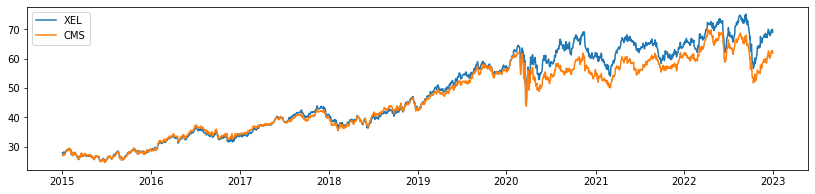

In [36]:
plt.figure(figsize=(14, 3))
plt.plot(prices.date.values, prices[company_1].values, label = company_1)
plt.plot(prices.date.values, prices[company_2].values, label = company_2)
_ = plt.legend()

In [37]:
i = 4
company_1, company_2 = pair_corr_df.iloc[i-1][['company_1', 'company_2']]

stocks[stocks.Symbol.isin([company_1, company_2])]

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
20,LNT,Alliant Energy,reports,Utilities,Electric Utilities,"Madison, Wisconsin",2016-07-01,352541,1917
115,CMS,CMS Energy,reports,Utilities,Multi-Utilities,"Jackson, Michigan",1999-05-03,811156,1886


In [38]:
i = 5
company_1, company_2 = pair_corr_df.iloc[i-1][['company_1', 'company_2']]

stocks[stocks.Symbol.isin([company_1, company_2])]

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
115,CMS,CMS Energy,reports,Utilities,Multi-Utilities,"Jackson, Michigan",1999-05-03,811156,1886
485,WEC,WEC Energy Group,reports,Utilities,Electric Utilities,"Milwaukee, Wisconsin",2008-10-31,783325,1896


### Top correlated companies from different sectors
Pepsi strongly correlates with Utilities sector

In [39]:
non_matching_sector_pair_df = pair_corr_df.loc[pair_corr_df["sector_1"] != pair_corr_df["sector_2"]]
non_matching_sector_pair_df.head(10)

,company_1,company_2,id_left,id_right,ret_1d,sector_1,sector_2,ret_5d,hret_1d,hret_5d,ewm_ret_1d,wt_hret_1d
439,XEL,PEP,450,325,0.661044,Utilities,Consumer Staples,0.558591,0.613447,0.606528,0.740396,0.579466
456,WEC,PEP,438,325,0.620008,Utilities,Consumer Staples,0.554899,0.607669,0.632998,0.605665,0.575708
460,UAL,CCL,413,76,0.735168,Industrials,Consumer Discretionary,0.781692,0.605846,0.665846,0.765569,0.636267
466,PEP,CMS,325,94,0.641648,Consumer Staples,Utilities,0.563526,0.604342,0.612640,0.643122,0.576394
535,WEC,PG,438,328,0.582669,Utilities,Consumer Staples,0.542612,0.588805,0.634191,0.695264,0.556489
544,UAL,NCLH,413,291,0.715586,Industrials,Consumer Discretionary,0.697506,0.586280,0.542605,0.757686,0.615034
555,PEP,ED,325,138,0.579016,Consumer Staples,Utilities,0.511037,0.581910,0.636832,0.574517,0.556315
557,PEP,AEP,325,14,0.615254,Consumer Staples,Utilities,0.546393,0.581441,0.583896,0.568410,0.554296
568,CMS,CL,94,87,0.591513,Utilities,Consumer Staples,0.538674,0.578040,0.610107,0.710947,0.549876
583,PEP,DUK,325,130,0.647808,Consumer Staples,Utilities,0.576623,0.574576,0.584466,0.672352,0.557365


In [40]:
stocks[stocks.Symbol.isin(['XEL', 'PEP'])]

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
367,PEP,PepsiCo Inc.,reports,Consumer Staples,Soft Drinks,"Purchase, New York",1957-03-04,77476,1898
497,XEL,Xcel Energy Inc,reports,Utilities,Multi-Utilities,"Minneapolis, Minnesota",1957-03-04,72903,1909


### Most Influential Industrials company
Waste Management Inc.

In [41]:
subset = ['Industrials', 'Consumer Staples']
local_df = non_matching_sector_pair_df[non_matching_sector_pair_df['sector_1'].isin(subset) & non_matching_sector_pair_df['sector_2'].isin(subset)]
company_1, company_2 = local_df.iloc[0][['company_1', 'company_2']]
stocks[stocks.Symbol.isin([company_1, company_2])]


,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
211,GIS,General Mills,reports,Consumer Staples,Packaged Foods & Meats,"Golden Valley, Minnesota",1969-03-31,40704,1856
483,WM,Waste Management Inc.,reports,Industrials,Environmental & Facilities Services,"Houston, Texas",NaN,823768,1968


In [42]:
subset = ['Industrials', 'Utilities']
local_df = non_matching_sector_pair_df[non_matching_sector_pair_df['sector_1'].isin(subset) & non_matching_sector_pair_df['sector_2'].isin(subset)]
company_1, company_2 = local_df.iloc[0][['company_1', 'company_2']]
stocks[stocks.Symbol.isin([company_1, company_2])]

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
123,ED,Consolidated Edison,reports,Utilities,Electric Utilities,"New York, New York",NaN,1047862,1823
483,WM,Waste Management Inc.,reports,Industrials,Environmental & Facilities Services,"Houston, Texas",NaN,823768,1968


## Next Steps to Try
- The best performing returns were hedged when counting the index return with equal weights. The next best returns were also hedged, but using weights proportional to stock's price. Therefore, assuming we can't have actual hedged returns using marketCap, we could try a grid search for best choice of weights.
- Trying to predict subsectors instead of sectors might work better depending on the definition of good clustering. There are so many subsectors of size e.g. 2 that have a pronounced positive correlation and would be easy to detect.